In [6]:
from keras.datasets import cifar10
from keras.utils import to_categorical
import warnings
from tensorflow.keras.models import Sequential
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch

warnings.filterwarnings("ignore")

# De CIFAR-10 dataset laden
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normaliseren van de pixelwaarden
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# One-hot encoding van de labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Definieer hyperparameters
hyperparameters = {
    'filters': [16, 32, 64],
    'kernel_size': [3, 5],
    'units': [32, 64, 128],
    'learning_rate': [1e-4, 1e-3, 1e-2]
}

def build_model(hp):
    model = Sequential([
        layers.Conv2D(
            filters=hp.Choice('filters', values=hyperparameters['filters']),
            kernel_size=hp.Choice('kernel_size', values=hyperparameters['kernel_size']),
            activation='relu',
            input_shape=(32, 32, 3)
        ),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(
            filters=hp.Choice('filters', values=hyperparameters['filters']),
            kernel_size=hp.Choice('kernel_size', values=hyperparameters['kernel_size']),
            activation='relu'
        ),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(
            units=hp.Choice('units', values=hyperparameters['units']),
            activation='relu'
        ),
        layers.Dense(10, activation='softmax')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=hyperparameters['learning_rate'])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=1, 
    executions_per_trial=1,
    directory='week8',  
    project_name='cifar10_cnn'
)

# Callback om overfitting te voorkomen en vroegtijdig te stoppen
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Start het zoeken
tuner.search(x_train, y_train, epochs=10, validation_split=0.1, callbacks=[stop_early])

# Toon de samenvatting van de beste 3 modellen
tuner.results_summary(3)


Trial 1 Complete [00h 05m 11s]
val_accuracy: 0.6901999711990356

Best val_accuracy So Far: 0.6901999711990356
Total elapsed time: 00h 05m 11s
Results summary
Results in my_dir/cifar10_cnn
Showing 3 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
filters: 48
kernel_size: 3
units: 64
learning_rate: 0.0003779766828406415
Score: 0.6901999711990356


In [7]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(x_train, y_train, epochs=5, validation_split=0.2)

Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 22ms/step - accuracy: 0.3374 - loss: 1.8470 - val_accuracy: 0.5015 - val_loss: 1.4016
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - accuracy: 0.5273 - loss: 1.3277 - val_accuracy: 0.5353 - val_loss: 1.3226
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.5786 - loss: 1.2017 - val_accuracy: 0.5905 - val_loss: 1.1733
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.6161 - loss: 1.0973 - val_accuracy: 0.6245 - val_loss: 1.0816
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - accuracy: 0.6419 - loss: 1.0263 - val_accuracy: 0.6193 - val_loss: 1.0916


In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred = best_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1) # decodeer de voorspelde klassen
y_true = np.argmax(y_test, axis=1)

# Genereer het classification report
report = classification_report(y_true, y_pred_classes)
print("Classification Report:\n", report)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.81      0.66      1000
           1       0.72      0.76      0.74      1000
           2       0.73      0.27      0.40      1000
           3       0.52      0.37      0.43      1000
           4       0.57      0.56      0.56      1000
           5       0.52      0.60      0.56      1000
           6       0.77      0.70      0.73      1000
           7       0.54      0.80      0.64      1000
           8       0.82      0.61      0.70      1000
           9       0.65      0.75      0.70      1000

    accuracy                           0.62     10000
   macro avg       0.64      0.62      0.61     10000
weighted avg       0.64      0.62      0.61     10000



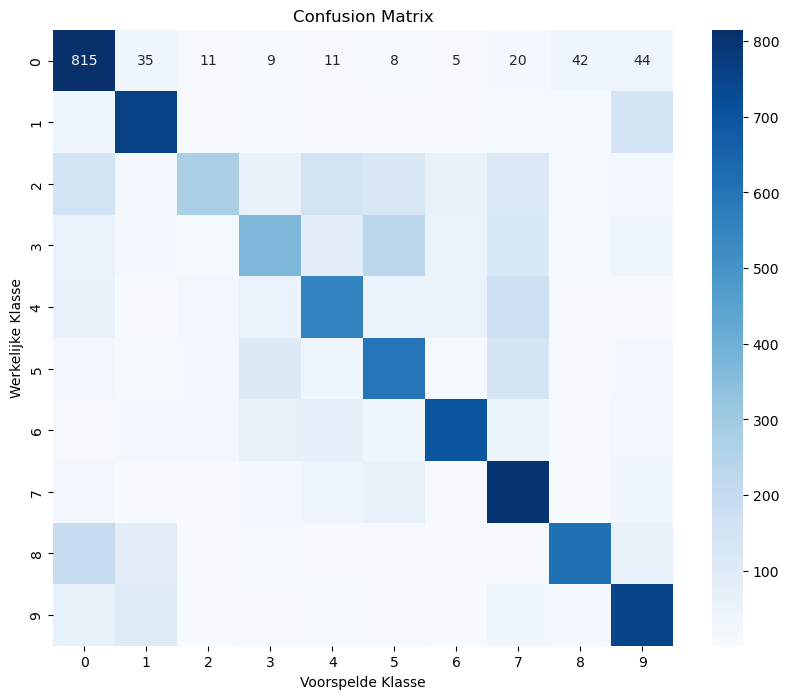

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Genereer de confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot de confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Werkelijke Klasse')
plt.xlabel('Voorspelde Klasse')
plt.show()


In [15]:
test_loss, test_acc = best_model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6261 - loss: 1.0761
Test accuracy: 0.6241000294685364


frog


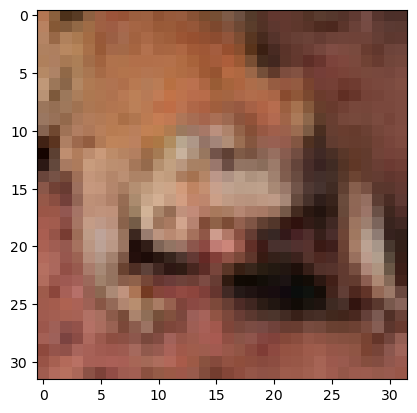

In [28]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

index = 5

print(class_names[y_pred_classes[index]])
plt.imshow(x_test[index])